In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

/opt/miniconda3/envs/tf_tcg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
perc = 75
predictors_type = 'original+detrend' # 'original', 'deseason', 'detrend', 'original+detrend' (original predictions, detrended for timeseries comparison)
# Set parameters for run name
if predictors_type == 'original' or predictors_type == 'original+detrend':
    n_clusters_dict = {'NEP': 7, 'NWP': 10, 'NA': 6, 'NI': 7, 'SI': 6, 'SP': 9}
    str_pt = 'nc'
elif predictors_type == 'deseason':
    n_clusters_dict = {'NEP': 6, 'NWP': 10, 'NA': 10, 'NI': 8, 'SI': 8, 'SP': 9}
    str_pt = 'DSnc'
elif predictors_type == 'detrend':
    n_clusters_dict = {'NEP': 12, 'NWP': 10, 'NA': 12, 'NI': 11, 'SI': 7, 'SP': 10}
    str_pt = 'DTnc'

In [3]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'xai-gpi')

In [4]:
basins = ['NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
for b, basin in enumerate(basins):
    # Set the predictors data and the target
    n_clusters = n_clusters_dict[basin]
    run_name = f'selfeat{perc}_top20_{str_pt}{n_clusters}_nv8_nd9'
    if predictors_type == 'deseason':
        cluster_data = f'{basin}_{n_clusters}clusters_deseason'
        target_file = 'target_deseasonal_1980-2022_2.5x2.5.csv'
    elif predictors_type == 'detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
        target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
    elif predictors_type == 'original+detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
        target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
    else:
        cluster_data = f'{basin}_{n_clusters}clusters'
        target_file = 'target_1980-2022_2.5x2.5.csv'
    cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
    # Get the run info and data
    Y_pred, Y_pred_noFS, _, _, mlps, mlps_noFS, _ = ut.runs_info(basin, run_name, project_dir, years)
    # Convert list of dataframes to a single dataframe
    Y_pred_df = pd.concat(Y_pred)
    Y_pred_noFS_df = pd.concat(Y_pred_noFS)
    # If predictions with original data are negative, set them to 0
    if predictors_type == 'original' or predictors_type == 'original+detrend':
        Y_pred_df[Y_pred_df < 0] = 0.0
        Y_pred_noFS_df[Y_pred_noFS_df < 0] = 0.0
    # Sum the predictions for each basin
    if b == 0:
        Y_pred_df_glb = Y_pred_df
        Y_pred_noFS_df_glb = Y_pred_noFS_df
    else:
        Y_pred_df_glb += Y_pred_df
        Y_pred_noFS_df_glb += Y_pred_noFS_df
    # Get time series for the North Atlantic
    if basin == 'NA':
        Y_pred_df_na = Y_pred_df
        Y_pred_noFS_df_na = Y_pred_noFS_df
        target_df_na = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
        target_df_na.index = pd.to_datetime(target_df_na.index)
        target_df_na = target_df_na.loc[target_df_na.index.year.isin(years)]
        gpis_file = f'{basin}_2.5x2.5_gpis_time_series.csv'
        gpis_df_na = pd.read_csv(os.path.join(fs_dir, 'data', gpis_file), index_col=0)
        gpis_df_na.index = pd.to_datetime(gpis_df_na.index)
        gpis_df_na = gpis_df_na.loc[gpis_df_na.index.year.isin(years)]
# Get the observations on the global scale
resolution = '2.5x2.5'
target_path = os.path.join(project_dir, 'data', 'IBTrACS', resolution, 'TCG', f'TCG_{resolution}')
tcg_ds = xr.concat([xr.open_dataset(target_path + f'_{year}.nc') for year in years], dim='time')
date_range = pd.date_range(start=f'{years[0]}-01-01', end=f'{years[-1]}-12-01', freq='MS')
target_df = pd.DataFrame(index=date_range)
target_df['tcg'] = tcg_ds.tcg.sum(dim=['latitude', 'longitude']).values.astype(int)
# gpis on the global scale
gpis_file = f'GLB_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# If predictions for original + detrend remove trend
if predictors_type == 'original+detrend':
    decomp_pred_FS = STL(Y_pred_df_glb['tcg']).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_df_glb['tcg']).fit()
    Y_pred_df_glb['tcg'] = Y_pred_df_glb['tcg'] - decomp_pred_FS.trend
    Y_pred_noFS_df_glb['tcg'] = Y_pred_noFS_df_glb['tcg'] - decomp_pred_noFS.trend
    decomp_pred_FS_na = STL(Y_pred_df_na['tcg']).fit()
    decomp_pred_noFS_na = STL(Y_pred_noFS_df_na['tcg']).fit()
    Y_pred_df_na['tcg'] = Y_pred_df_na['tcg'] - decomp_pred_FS_na.trend
    Y_pred_noFS_df_na['tcg'] = Y_pred_noFS_df_na['tcg'] - decomp_pred_noFS_na.trend

In [5]:
# Annual data 
Y_pred_df_glb_annual = Y_pred_df_glb.groupby(Y_pred_df_glb.index.year).sum()
Y_pred_noFS_df_glb_annual = Y_pred_noFS_df_glb.groupby(Y_pred_noFS_df_glb.index.year).sum()
Y_pred_df_na_annual = Y_pred_df_na.groupby(Y_pred_df_na.index.year).sum()
Y_pred_noFS_df_na_annual = Y_pred_noFS_df_na.groupby(Y_pred_noFS_df_na.index.year).sum()
# GPIs time series 
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
decomp_engpi = STL(engpi_TS).fit()
decomp_ogpi = STL(ogpi_TS).fit()
engpi_TS_na = gpis_df_na['engpi']
ogpi_TS_na = gpis_df_na['ogpi']
decomp_engpi_na = STL(engpi_TS_na).fit()
decomp_ogpi_na = STL(ogpi_TS_na).fit()
decomp_target = STL(target_df['tcg']).fit()
if predictors_type == 'deseason':
    engpi = engpi_TS - decomp_engpi.seasonal
    ogpi = ogpi_TS - decomp_ogpi.seasonal
    engpi_na = engpi_TS_na - decomp_engpi_na.seasonal
    ogpi_na = ogpi_TS_na - decomp_ogpi_na.seasonal
    target = target_df['tcg'] - decomp_target.seasonal
elif predictors_type == 'detrend' or predictors_type == 'original+detrend':
    engpi = engpi_TS - decomp_engpi.trend
    ogpi = ogpi_TS - decomp_ogpi.trend
    engpi_na = engpi_TS_na - decomp_engpi_na.trend
    ogpi_na = ogpi_TS_na - decomp_ogpi_na.trend
    target = target_df['tcg'] - decomp_target.trend
else:
    engpi = engpi_TS
    ogpi = ogpi_TS
    engpi_na = engpi_TS_na
    ogpi_na = ogpi_TS_na
    target = target_df['tcg']
target_na = target_df_na['tcg']
# Annual data of the GPIs
target_annual = target.groupby(target.index.year).sum()
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
target_annual_na = target_na.groupby(target_na.index.year).sum()
engpi_annual_na = engpi_na.groupby(engpi_na.index.year).sum()
ogpi_annual_na = ogpi_na.groupby(ogpi_na.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Annual 
rY, p_valueY = pearsonr(target_annual, Y_pred_df_glb_annual['tcg'])
rY_noFS, p_value_noFSY = pearsonr(target_annual, Y_pred_noFS_df_glb_annual['tcg'])
rY_engpi, p_value_engpiY = pearsonr(target_annual, engpi_annual)
rY_ogpi, p_value_ogpiY = pearsonr(target_annual, ogpi_annual)
rY_na, p_value_naY = pearsonr(target_annual_na, Y_pred_df_na_annual['tcg'])
rY_noFS_na, p_value_noFS_naY = pearsonr(target_annual_na, Y_pred_noFS_df_na_annual['tcg'])
rY_engpi_na, p_value_engpi_naY = pearsonr(target_annual_na, engpi_annual_na)
rY_ogpi_na, p_value_ogpi_naY = pearsonr(target_annual_na, ogpi_annual_na)

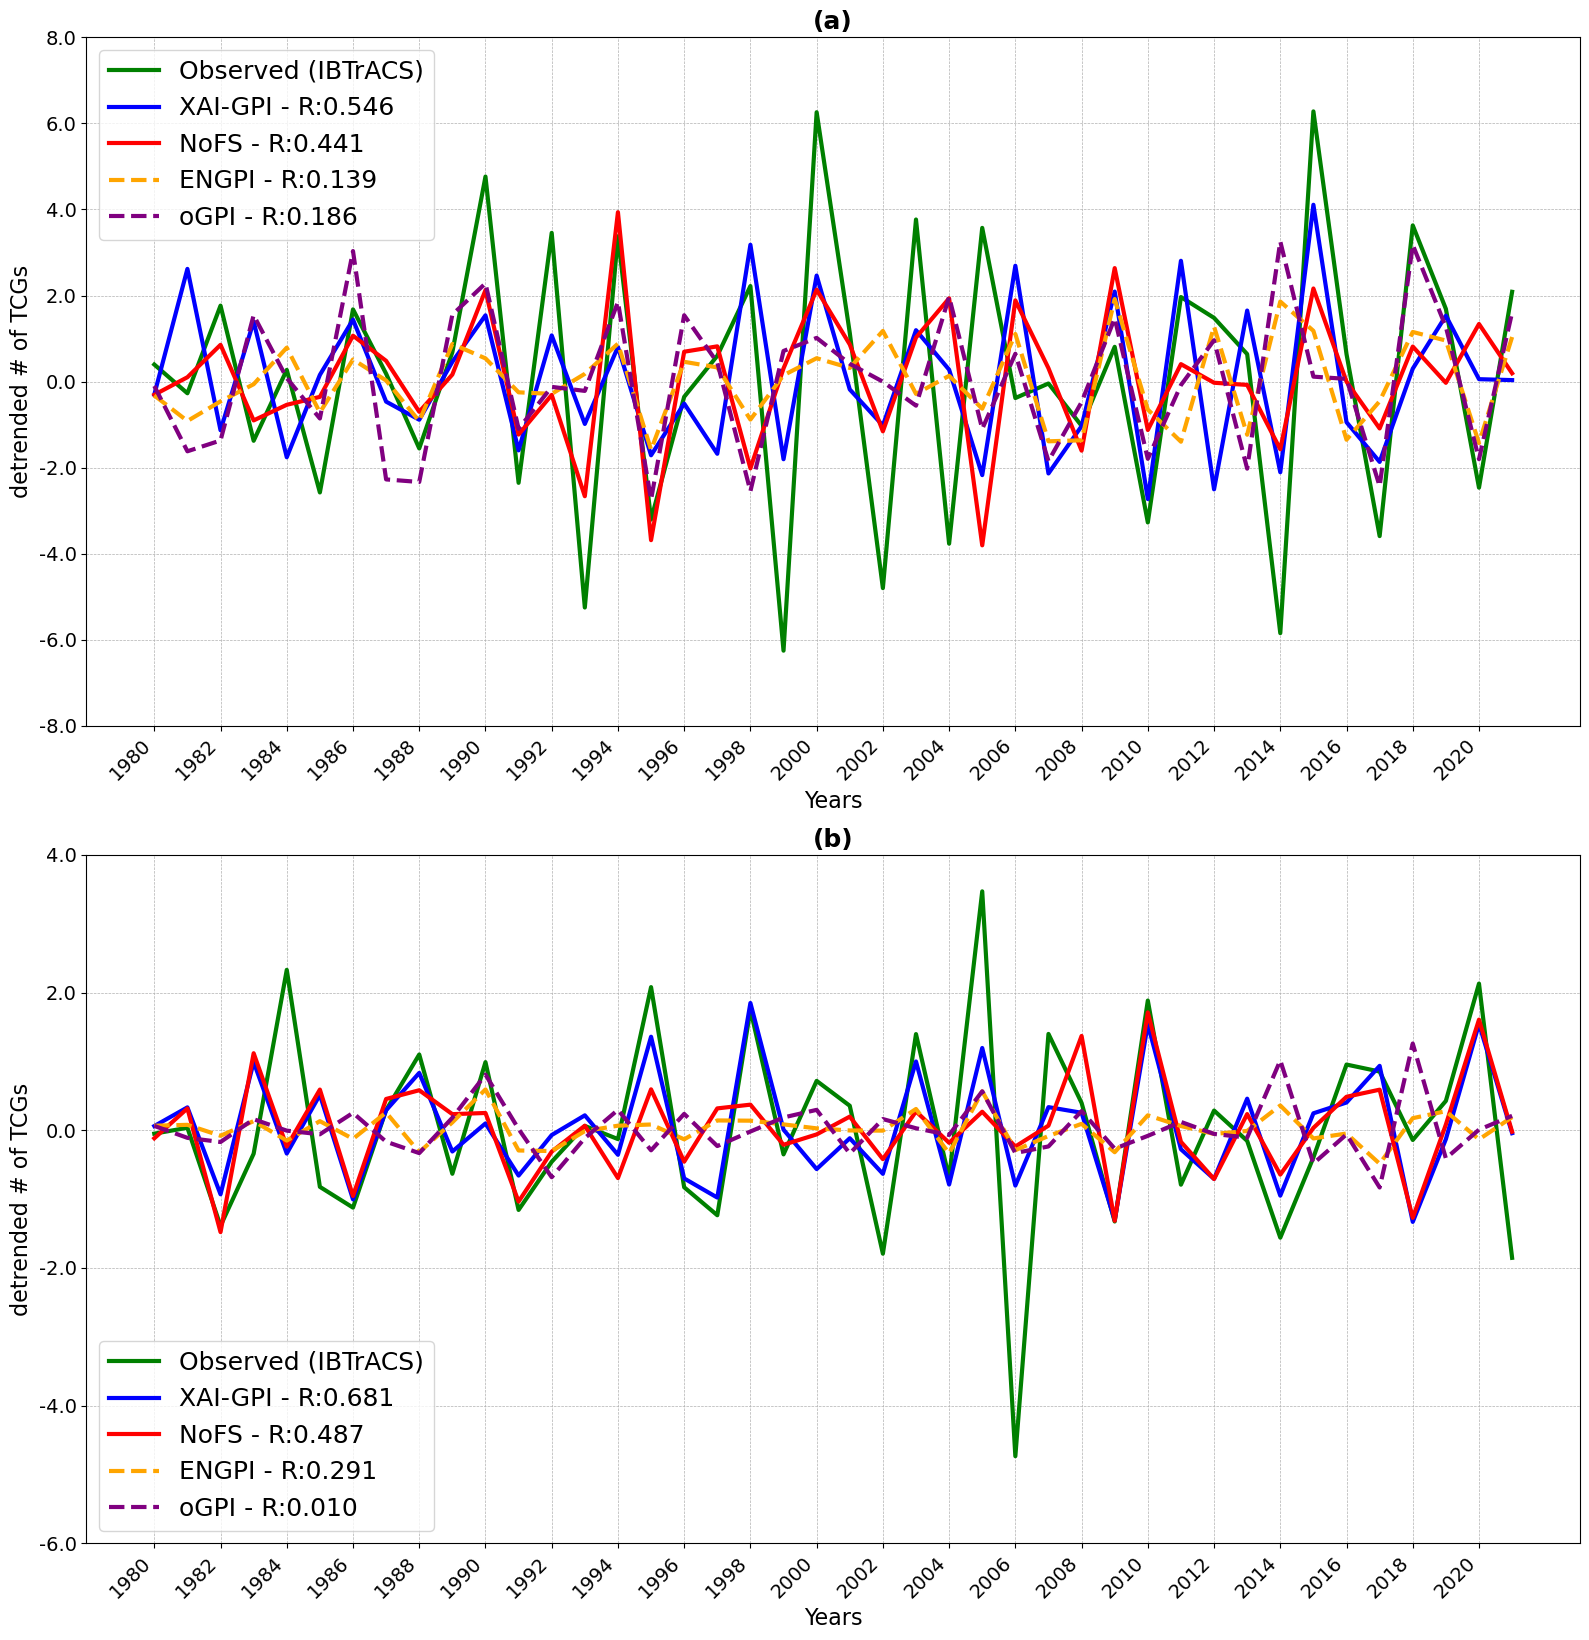

In [6]:
fig_annual = plt.figure(figsize=(16, 16.5))
gs = GridSpec(2, 1, height_ratios=[1, 1], figure=fig_annual)
# Global scale
axG = fig_annual.add_subplot(gs[0])
# observations
axG.plot(target_annual.index, target_annual, label='Observed (IBTrACS)', color='green', linewidth=3)
# mlp predictions
axG.plot(Y_pred_df_glb_annual['tcg'].index, Y_pred_df_glb_annual['tcg'], label=f'XAI-GPI - R:{rY:.3f}', color='blue', linewidth=3)
axG.plot(Y_pred_noFS_df_glb_annual['tcg'].index, Y_pred_noFS_df_glb_annual['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=3)
# gpis
axG.plot(engpi_annual.index, engpi_annual, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=3, linestyle='--')
axG.plot(ogpi_annual.index, ogpi_annual, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=3, linestyle='--')
# set figure parameters
axG.grid(True, which='both', linestyle='--', linewidth=0.5)
axG.set_xticks(target_annual.index[::2])
axG.set_xticklabels(target_annual.index[::2], rotation=45, fontsize=14, ha='right')
axG.set_yticks(axG.get_yticks())
axG.set_yticklabels(axG.get_yticks(), fontsize=14)
axG.set_xlabel('Years', fontsize=16)
axG.set_ylabel('detrended # of TCGs', fontsize=16)
axG.legend(fontsize=18, loc='best')
axG.set_title('(a)', fontsize=18, fontweight='bold')
# North Atlantic
axNA = fig_annual.add_subplot(gs[1])
# observations
axNA.plot(target_annual_na.index, target_annual_na, label='Observed (IBTrACS)', color='green', linewidth=3)
# mlp predictions
axNA.plot(Y_pred_df_na_annual['tcg'].index, Y_pred_df_na_annual['tcg'], label=f'XAI-GPI - R:{rY_na:.3f}', color='blue', linewidth=3)
axNA.plot(Y_pred_noFS_df_na_annual['tcg'].index, Y_pred_noFS_df_na_annual['tcg'], label=f'NoFS - R:{rY_noFS_na:.3f}', color='red', linewidth=3)
# gpis
axNA.plot(engpi_annual_na.index, engpi_annual_na, label=f'ENGPI - R:{rY_engpi_na:.3f}', color='orange', linewidth=3, linestyle='--')
axNA.plot(ogpi_annual_na.index, ogpi_annual_na, label=f'oGPI - R:{rY_ogpi_na:.3f}', color='purple', linewidth=3, linestyle='--')
# set figure parameters
axNA.grid(True, which='both', linestyle='--', linewidth=0.5)
axNA.set_xticks(target_annual_na.index[::2])
axNA.set_xticklabels(target_annual_na.index[::2], rotation=45, fontsize=14, ha='right')
axNA.set_yticks(axNA.get_yticks())
axNA.set_yticklabels(axNA.get_yticks(), fontsize=14)
axNA.set_xlabel('Years', fontsize=16)
axNA.set_ylabel('detrended # of TCGs', fontsize=16)
axNA.legend(fontsize=18, loc='best')
axNA.set_title('(b)', fontsize=18, fontweight='bold')
# Finalize the figure
fig_annual.set_tight_layout(True)
fig_annual.savefig(os.path.join(fs_dir, 'best_model_analysis', 'figures', f'GLB+NA_annual_time_series.pdf'), format='pdf', dpi=300, bbox_inches='tight')